# 四、建模預測
<hr style="border:2px solid gray">

由於各個用戶的訂單特性都不盡相同，所以固定的 0 或 1 預測方法可能無法適用於所有訂單的情況。

因此我們使用 XGBoost 模型訓練，並預測每個產品被重新訂購的機率後，再根據不同的訂單調整閾值，從而獲得更好的預測效果。

### 具體的流程總結：

1. 將原先的訓練集隨機分割成測試集和驗證集 (9:1)。

2. 使用 Random search 進行超參數優化，取得最佳參數。

3. 使用最佳參數建立 XGBoost 模型，並進行訓練。

4. 使用訓練好的模型預測測試數據，獲得每個產品被重新訂購的概率。

5. 最終根據每個訂單的條件，調整閾值以最大化 F1-score。



In [1]:
# 載入所需套件
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, log_loss
from tqdm import tqdm
import pickle
from f1optimization_faron import get_best_prediction
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from prettytable import PrettyTable

In [2]:
# 讀取 train 和 test
path = './datasets/train_test_data.h5'
train_data = pd.read_hdf(path, key='train')
test_data = pd.read_hdf(path, key='test')

# 4-1. 輔助機器學習過程中的數據處理與可視化
<hr style="border:2px solid gray">

### 4-1-1. `display_target_distribution` 此函數用於顯示訓練集和驗證集目標變數的分布情況

In [3]:
def display_target_distribution(y_train, y_val):
    # 計算訓練數據和驗證數據中每個目標值的計數
    # return_counts = True
    # 第一個元素是數組中所有唯一值
    # 第二個元素是每個唯一值的計數
    _, train_label_counts = np.unique(y_train, return_counts=True)
    _, val_label_counts = np.unique(y_val, return_counts=True)

    # 設置 bar chart 的參數
    width = 0.35  # 寬度
    x = np.arange(2) # x 軸上的位置
    fig, ax = plt.subplots(figsize=(12,6))
    # 繪製訓練數據和驗證數據的 bar chart
    rects1 = ax.bar(x - width/2, train_label_counts, width, label='Train')
    rects2 = ax.bar(x + width/2, val_label_counts, width, label='validation')

    ax.set_ylabel('Number of data points')
    ax.set_title('Distribution of the Output Variable')
    ax.set_xticks(x) # 設置 x 軸刻度
    ax.set_xticklabels([0,1]) # 設置 x 軸刻度標籤
    ax.legend()
    plt.show()

### 4-1-2. `random_split` 此函數用於隨機將數據分割成訓練集和驗證集

In [4]:

def random_split(test_size=0.1, random_state=123):
    # 提取目標變量和特徵
    train_y = train_data['reordered'].values.tolist()
    train_x = train_data.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis = 1)
    # 注意：加入參數 stratify=train_y 才能確保驗證集的目標變量分布和原先訓練集的一致！
    X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=test_size, random_state=random_state)
    # 檢查：顯示目標變量的分布情況
    display_target_distribution(y_train, y_val)
    return (X_train, y_train),(X_val, y_val)


# 4-2. 資料隨機分割為訓練和驗證集
<hr style="border:2px solid gray">

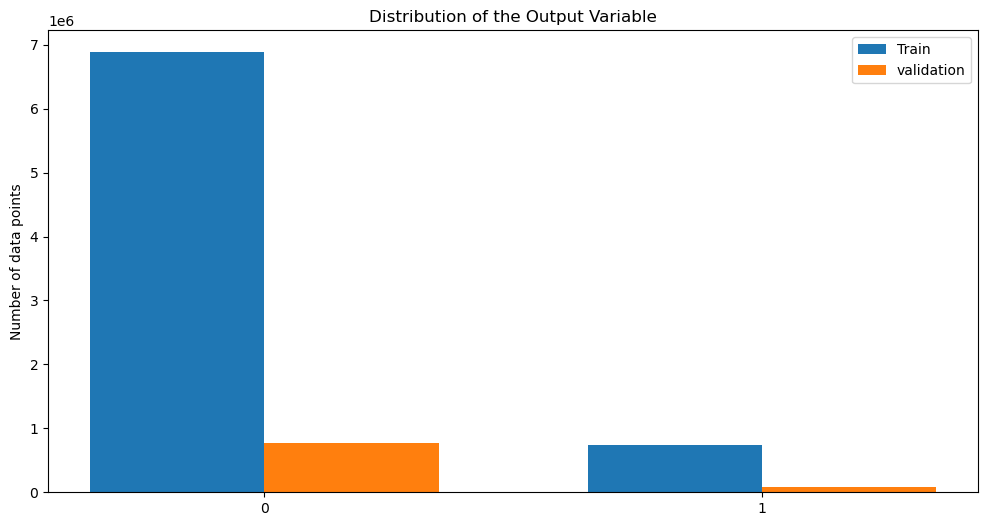

In [5]:
(X_train, y_train), (X_val, y_val) = random_split(test_size = 0.1)

# 4-3. 訓練 XGboost 模型
<hr style="border:2px solid gray">

### `train_xgb` 此函數用於訓練 XGBoost 模型

訓練模型的流程為：

1. 利用 Random Search 進行超參數的優化，找到最佳的模型參數。
2. 接著利用最佳參數建立 XGBoost 模型，並進行訓練。

參數說明：

    X_train, X_val, y_train, y_val  ：為傳入的訓練和驗證的數據集。
    plot_importance                 ：是否繪製特徵重要性圖，預設為 True。
    save                            ：是否保存訓練好的模型，預設為　True。
    file_name                       ：保存模型的檔案名稱，預設為 None。
    params                          ：提供模型參數，預設是 None 進行超參數優化。

回傳：

    xgb_model                       ：訓練好的 model。
    predict_y                       ：驗證集各個樣本預測為 1 的機率。

In [6]:
def train_xgb(X_train, X_val, y_train, y_val, plot_importance=True, save=True, file_name=None, params=None):

    # 如果沒有提供自訂的參數，會使用以下的初始參數進行超參數的優化，接著進行模型訓練
    if params is None:
        initial_params = {
            'objective': 'binary:logistic',     # 目標函數為二元分類問題的邏輯迴歸
            'eval_metric': 'logloss',           # logloss為評估模型的標準
            'nthread': 5,                       # 等同於 scikit-learn 中的 n_jobs，是設定要使用多少顆 CPU 的參數
            'tree_method': 'hist',              # 使用 'hist' 來構建決策樹
            'device': 'cuda'                    # 使用 GPU 來加速計算
        }

        param_dist = {
            'eta': uniform(0.01, 0.1),                  # 又稱作學習率，決定每一部優化的步長大小
            'max_depth': randint(3, 15),                # 每顆樹的最大深度
            'colsample_bytree': uniform(0.3, 0.7),      # 指定了每顆樹選取的特徵比例，有助於減少過擬合
            'subsample': uniform(0.3, 0.7),             # 訓練時使用的樣本比例
            'n_estimators': randint(100, 500)           # 訓練時樹的總數量
        }

        xgb_model = xgb.XGBClassifier(**initial_params)

        random_search = RandomizedSearchCV(
            xgb_model,
            param_distributions=param_dist,
            n_iter=50,                          # 總共嘗試的不同參數組合
            scoring='neg_log_loss',             # 由於 log_loss 是越小越好，但要適用於RandomizedSearchCV需要越大越好，因此使用 neg_log_loss
            cv=3,                               # 交叉驗證的 folds
            verbose=1,                          # 輸出基本訊息
            random_state=123,
            n_jobs=5
        )

        random_search.fit(X_train, y_train)
        best_params = random_search.best_params_
        print("經過超參數的優化後，最佳參數為:", best_params)
        params = initial_params         # 先給定初始參數的字典
        params.update(best_params)      # 最後加入最佳參數


    # watchlist 用於模型訓練過程中的評估。
    watchlist = [(X_train, y_train), (X_val, y_val)] # 固定格式

    # 使用最佳參數來創建和訓練模型

    # 建立模型
    # early_stopping_rounds=20 表示如果在 20 次迭代內，驗證集的評估指標沒有改善，則訓練會提前停止，以防止過擬合的情況發生。
    xgb_model = xgb.XGBClassifier(**params, early_stopping_rounds=20)

    print("開始訓練：")
    # XGBoost (xgb.train) 使用增強決策樹（Boosted Decision Trees）的方法來更新模型，具體的作法是基於梯度提升（Gradient Boosting）的原理。
    # XGBoost 在每一棵樹之間，模型會計算當前的預測結果與實際結果之間的誤差，然後根據這個誤差來更新模型特徵的權重，使其在每次迭代後都能更好地擬合
    # verbose_eval=10 表示每 10 次迭代會輸出一次當前的評估結果。
    xgb_model.fit(X_train, y_train, eval_set=watchlist, verbose=10)
    print("完成訓練！")

    # 取得驗證集各個樣本預測為 1 的機率
    # 使用 inplace_predict 進行預測以確保數據在 GPU 上
    predict_y = xgb_model.get_booster().inplace_predict(X_val)
    print("最終驗證集的 log loss 為：", log_loss(y_val, predict_y))

    # 保存訓練好的模型
    if save and file_name:
        # with 它會自動確保文件操作完後正確關閉
        with open(file_name, "wb") as f:  # wb 二進制寫入模式
            pickle.dump(xgb_model, f)

    # 繪製特徵重要性圖
    if plot_importance:
        print("特徵重要性")
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        xgb.plot_importance(booster=xgb_model, ax=ax)
        plt.show()

    return xgb_model, predict_y

在 CPU 設定為 5 的情況下，具體的超參數優化會耗費長達 6 個多小時，請依電腦效能情況調整。

經過超參數的優化後，最佳參數為:
{'colsample_bytree': 0.9128197892566223, 'eta': 0.06104223374780112, <br>
 'max_depth': 12, 'n_estimators': 454, 'subsample': 0.710155586793549}

In [22]:
# 設定最佳參數
best_params = {
    'objective': 'binary:logistic',             # 目標函數為二元分類問題的邏輯迴歸
    'eval_metric': 'logloss',                   # logloss為評估模型的標準
    'nthread': 5,                               # 等同於 scikit-learn 中的 n_jobs，是設定要使用多少顆 CPU 的參數
    'tree_method': 'hist',                      # 使用 'hist' 來構建決策樹
    'device': 'cuda',                           # 使用 GPU 來加速計算

    'eta': 0.06104223374780112,                 # 又稱作學習率，決定每一部優化的步長大小
    'max_depth': 12,                            # 每顆樹的最大深度
    'colsample_bytree': 0.9128197892566223,     # 指定了每顆樹選取的特徵比例，有助於減少過擬合
    'subsample': 0.710155586793549,             # 訓練時使用的樣本比例
    'n_estimators': 454                         # 訓練時樹的總數量
}

開始訓練：
[0]	validation_0-logloss:0.33015	validation_1-logloss:0.33028
[10]	validation_0-logloss:0.27693	validation_1-logloss:0.27841
[20]	validation_0-logloss:0.25526	validation_1-logloss:0.25800
[30]	validation_0-logloss:0.24550	validation_1-logloss:0.24951
[40]	validation_0-logloss:0.24061	validation_1-logloss:0.24585
[50]	validation_0-logloss:0.23773	validation_1-logloss:0.24415
[60]	validation_0-logloss:0.23588	validation_1-logloss:0.24337
[70]	validation_0-logloss:0.23441	validation_1-logloss:0.24294
[80]	validation_0-logloss:0.23314	validation_1-logloss:0.24262
[90]	validation_0-logloss:0.23201	validation_1-logloss:0.24234
[100]	validation_0-logloss:0.23103	validation_1-logloss:0.24212
[110]	validation_0-logloss:0.23018	validation_1-logloss:0.24198
[120]	validation_0-logloss:0.22931	validation_1-logloss:0.24180
[130]	validation_0-logloss:0.22843	validation_1-logloss:0.24165
[140]	validation_0-logloss:0.22759	validation_1-logloss:0.24151
[150]	validation_0-logloss:0.22670	validation

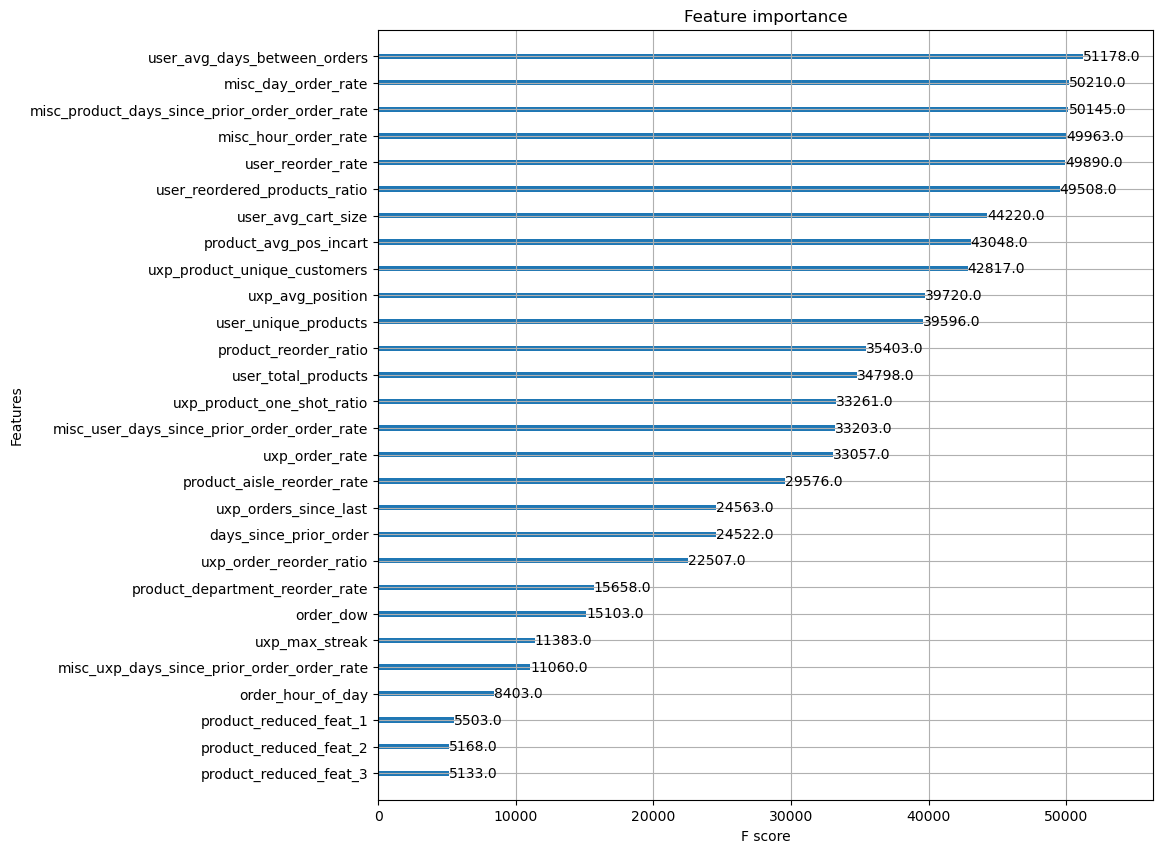

In [23]:
xgb_model, predict_y = train_xgb(X_train, X_val, y_train, y_val, True, True, "./datasets/xgb_v1.pkl", params=best_params)

精確率(Precision) 通常在預測正例的重要性高於預測負例時，是非常重要的指標。

- 準確率(Accuracy) 反映了模型在所有預測中有多少是正確的，但在不平衡的情況下，準確率可能無法解釋在少數類別上的情形。
- 精確率(Precision) 預測為正的結果中有多少是正確的

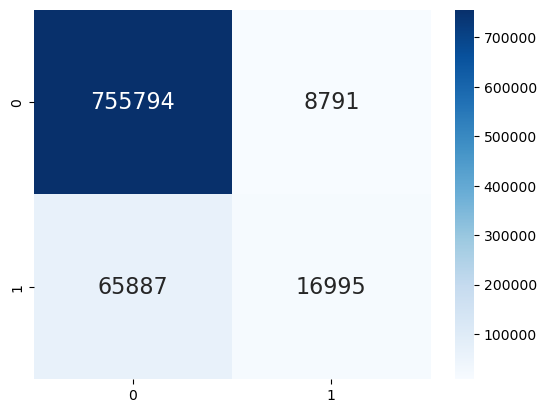

Accuracy : 0.9118809345968634
Precision : 0.65907856976654


In [24]:
# 先給定計算二元分類的預測標籤閾值為 0.5
predicted_y = np.array(predict_y > 0.5, dtype=int)
# 計算混淆矩陣
cm = confusion_matrix(y_val, predicted_y)

# 繪製混淆矩陣
sns.heatmap(cm, cmap='Blues', annot = True, fmt="g", annot_kws={"size": 16})
plt.show()
print("Accuracy :",accuracy_score(y_val, predicted_y))
print("Precision :",precision_score(y_val, predicted_y))

# 4-4. 對測試集進行預測並給出產品列表
<hr style="border:2px solid gray">

### `getscores_on_testdata` 此函數用於預測並回傳每個訂單的產品列表

流程為：

1. 利用訓練好的模型進行預測，得到各個產品的重購的機率。
2. 接著利用 Faron 的 F1-score 最大化進行各別訂單閾值的調整。
3. 最後回傳產品列表。

參數說明：

    model           ：訓練好的模型
    scaler          ：是否標準化
    model_type      ：模型的種類
    val_file        ：測試集的位置

回傳：

    test_products   ：每個訂單的產品列表

In [25]:
def getscores_on_testdata(model=None, scaler=None, model_type='xgb', val_file=path):
    # 讀取測試數據
    test_data = pd.HDFStore(val_file)
    test_data = test_data['test']
    data = test_data.drop(['user_id', 'product_id', 'order_id'], axis = 1)

    if scaler != None:
        data = scaler.transform(data) # 對測試數據進行標準化

    # 根據模型類型進行預測
    if model_type == 'xgb':
      ypred = model.predict_proba(data)[:, 1]

    # 將預測重新訂購的機率添加到 test_data
    test_data['reordered'] =  ypred

    # 創建一個包含 orderID 和所有可能的 productID 列表的 DataFrame
    test_products = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()

    # 添加每個 orderID 的所有重新訂購的機率到列表中
    test_products['probs'] = test_data.groupby(['order_id'])['reordered'].apply(list).reset_index()['reordered']

    # 執行 Faron 的優化，以獲取可能被重新訂購的產品的最可能集合
    products = []

    # 用 tqdm 來顯示進度條
    for i in tqdm(test_products.index):
        prods = get_best_prediction(test_products.iloc[i]['product_id'], test_products.iloc[i]['probs'], None)
        products.append(prods)

    test_products['products']= products

    test_products['order_id'] = test_products['order_id'].apply(int)
    test_products.drop(['product_id','probs'], axis = 1, inplace = True)

    return test_products

In [26]:
# 生成基於局部閾值的產品列表
# pickle.load() 加載訓練好的模型
from f1optimization_faron import get_best_prediction
test_products = getscores_on_testdata(model = pickle.load(open("./datasets/xgb_v1.pkl", "rb")), model_type ='xgb')
test_products.to_csv("./datasets/sub_xgb_v1.csv", index= False)

100%|██████████| 75000/75000 [14:53<00:00, 83.95it/s] 


# 4-5. 提交結果
<hr style="border:2px solid gray">

In [3]:
x = PrettyTable()
x.field_names = ["Model", "logloss", "Private Score" ,"Public Score"]
x.add_row(['XGBoost','0.2398', '0.39593','0.39662'])
print(x)

+---------+---------+---------------+--------------+
|  Model  | logloss | Private Score | Public Score |
+---------+---------+---------------+--------------+
| XGBoost |  0.2398 |    0.39593    |   0.39662    |
+---------+---------+---------------+--------------+
